# 22장 시퀀스 배열로 다루는 순환 신경망

## 1. LSTM을 이용한 로이터 뉴스 카테고리 분류하기

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import reuters       # 로이터 뉴스 데이터셋 불러오기
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눕니다.
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

# 데이터를 확인해 보겠습니다.
category = np.max(y_train) + 1
print(category, '카테고리')
print(len(X_train), '학습용 뉴스 기사')
print(len(X_test), '테스트용 뉴스 기사')
print(X_train[0])

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
46 카테고리
8982 학습용 뉴스 기사
2246 테스트용 뉴스 기사
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [2]:
# 단어의 수를 맞추어 줍니다.
X_train = sequence.pad_sequences(X_train, maxlen=100)
X_test = sequence.pad_sequences(X_test, maxlen=100)

# 원-핫 인코딩 처리를 합니다.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# 모델의 구조를 설정합니다.
model = Sequential()
model.add(Embedding(1000, 100))
model.add(LSTM(100, activation='tanh'))
model.add(Dense(46, activation='softmax'))

# 모델의 실행 옵션을 정합니다.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# 모델을 실행합니다.
history = model.fit(X_train, y_train, batch_size=20, epochs=200, validation_data=(X_test, y_test), callbacks=[early_stopping_callback])

# 테스트 정확도를 출력합니다.
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.3989 - loss: 2.4384 - val_accuracy: 0.4751 - val_loss: 2.0723
Epoch 2/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5190 - loss: 1.8438 - val_accuracy: 0.5708 - val_loss: 1.7039
Epoch 3/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5750 - loss: 1.6643 - val_accuracy: 0.5890 - val_loss: 1.5907
Epoch 4/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6163 - loss: 1.5174 - val_accuracy: 0.6184 - val_loss: 1.5177
Epoch 5/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6390 - loss: 1.4035 - val_accuracy: 0.6478 - val_loss: 1.3843
Epoch 6/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6895 - loss: 1.2347 - val_accuracy: 0.6638 - val_loss: 1.3014
Epoch 7/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7108 - loss: 1.1127 - val_accuracy: 0.6866 - val_loss: 1.2283
Epoch 8/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7222 - loss: 1.0890 - val_ac

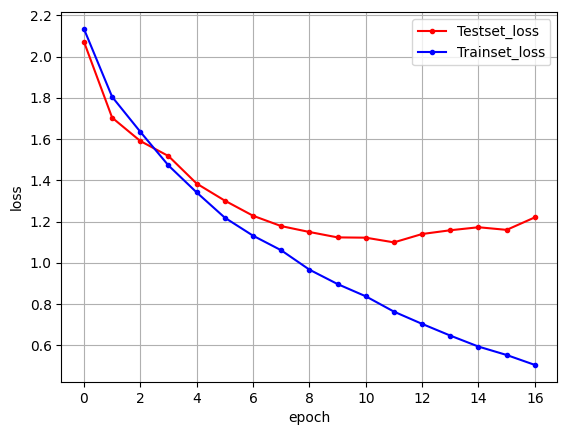

In [3]:
# 학습셋과 테스트셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 2. LSTM과 CNN의 조합을 이용한 영화 리뷰 분류하기

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눕니다.
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

# 단어의 수를 맞추어 줍니다.
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

# 모델의 구조를 설정합니다.
model = Sequential()
model.add(Embedding(5000, 100))
model.build((None, 500))
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, padding='valid', activation='relu',strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(55))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 100)       │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 496, 64)        │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 124, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 55)             │        26,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 558,520 (2.13 MB)

 Trainable params: 558,520 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [2]:
# 모델의 실행 옵션을 정합니다.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

# 모델을 실행합니다.
history = model.fit(X_train, y_train, batch_size=40, epochs=100, validation_split=0.25, callbacks=[early_stopping_callback])

# 테스트 정확도를 출력합니다.
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.6767 - loss: 0.5565 - val_accuracy: 0.8875 - val_loss: 0.2772
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9098 - loss: 0.2361 - val_accuracy: 0.8875 - val_loss: 0.2764
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9287 - loss: 0.1835 - val_accuracy: 0.8923 - val_loss: 0.2616
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9486 - loss: 0.1478 - val_accuracy: 0.8930 - val_loss: 0.2856
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.9624 - loss: 0.1100 - val_accuracy: 0.8888 - val_loss: 0.2979
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9709 - loss: 0.0885 - val_accuracy: 0.8867 - val_loss: 0.3597
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8783 - loss: 0.3883

 Test Accuracy: 0.8786


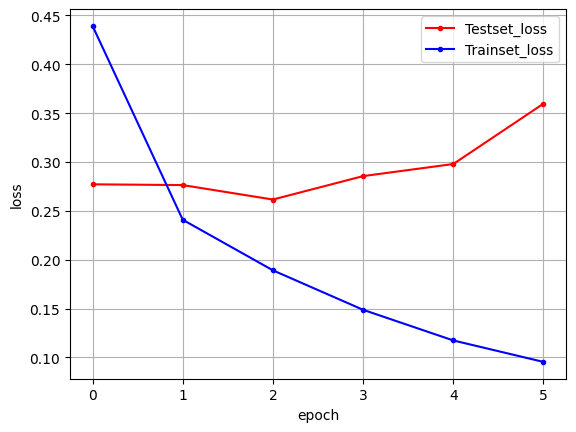

In [3]:
# 학습셋과 테스트셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

## 3. Seq2Seq 모델과 어텐션

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.1250 - loss: 4.1079 - val_accuracy: 0.0000e+00 - val_loss: 4.0995
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5000 - loss: 4.0930 - val_accuracy: 0.0000e+00 - val_loss: 4.0911
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5000 - loss: 4.0777 - val_accuracy: 0.0000e+00 - val_loss: 4.0822
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5000 - loss: 4.0614 - val_accuracy: 0.0000e+00 - val_loss: 4.0725
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5000 - loss: 4.0434 - val_accuracy: 0.0000e+00 - val_loss: 4.0616
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5000 - loss: 4.0228 - val_accuracy: 0.0000e+00 - val_loss: 4.0490
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.5000 - loss: 3.9988 - val_accuracy: 0.0000e+00 - val_loss: 4.0344
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5000 - loss: 3.9704 - val_accuracy: 

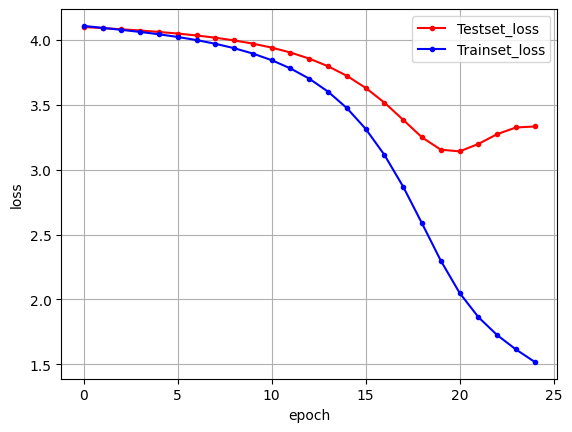

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

# 예제용 데이터셋
# 한국어 입력 (X_data)
# "오늘 날씨 어때"   → [1, 2, 3]
# "오늘 주가 얼마"   → [1, 4, 5]
# "날씨가 점점 따뜻해" → [6, 7, 8]
X_data = [
    [1, 2, 3],
    [1, 4, 5],
    [6, 7, 8]
]

# 영어 출력 (Y_data)
# "It is warm"  → [10, 20, 30]
# "It is high"  → [10, 20, 50]
# "Getting warm" → [60, 30]
Y_data = [
    [10, 20, 30],
    [10, 20, 50],
    [60, 30]
]

# 패딩
X_train = pad_sequences(X_data, maxlen=5)  # 입력 시퀀스를 길이 5로 맞춤
Y_train = pad_sequences(Y_data, maxlen=4)  # 출력 시퀀스를 길이 4로 맞춤

# 입력 단어 집합 크기와 출력 단어 집합 크기 자동 설정
# np.max(X_train)와 np.max(Y_train)을 통해 등장하는 단어의 최댓값(인덱스)를 구한 뒤, +1을 해준다.
input_vocab_size = np.max(X_train) + 1
output_vocab_size = np.max(Y_train) + 1

# 원-핫 인코딩 (출력 데이터용)
y_train = to_categorical(Y_train, num_classes=output_vocab_size)

# 인코더 정의
encoder_inputs = Input(shape=(5,))
enc_emb = Embedding(input_dim=input_vocab_size, output_dim=64)(encoder_inputs)
encoder_lstm = LSTM(128, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

# 디코더 정의
decoder_inputs = Input(shape=(4,))
dec_emb = Embedding(input_dim=output_vocab_size, output_dim=64)(decoder_inputs)
decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# 모델 구성
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습
history = model.fit([X_train, Y_train], y_train, batch_size=2, epochs=25, validation_split=0.2)

# 학습 과정 시각화
y_vloss = history.history['val_loss']
y_loss = history.history['loss']
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
